# Wav2Vec2-Base
## Overview
- We now import a pre-trained model from HuggingFace 🤗 and fine-tune it on a labelled dataset. Then, we test its performace on our usual benchmark dataset (LibriSpeech). In particular, the model ([Wav2Vec2](https://huggingface.co/docs/transformers/model_doc/wav2vec2)) was pre-trained in a complete unsupervised fashion using Masked Language Modeling (MLM) and constrastive learning to learn good audio features. As suggested in the paper, we will not fine-tune the feature extractor module because it already has good weights. During fine-tuning, we pick different splits both from [LIBRISPEECH](https://huggingface.co/datasets/librispeech_asr) (train-clean-100) and [FLEURS](https://huggingface.co/datasets/google/fleurs) labelled speech dataset. We then assess the performance of the fine-tuned model on the Librispeech benchmark (dev-clean, dev-other, test-clean, test-other). We believe that given a well-enough pre-trained model, is it sufficient to fine-tune it on few examples (<1 hour of labelled speech) to obtain sufficiently good performance on unseen audio data.

## Libraries

In [1]:
# Main libraries
import numpy as np
import torch
import pandas as pd
import accelerate

# Datasets
from datasets import load_dataset, load_metric
from torch.utils.data import DataLoader
from datasets import Dataset as HFDataset
from utils.preprocessing import Preprocessing

# Hugging Face
from transformers import Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2FeatureExtractor
from transformers import Wav2Vec2Processor
from transformers import Wav2Vec2ForCTC
from transformers import TrainingArguments
from transformers import Trainer

# Others
import re
import inflect
import json
import IPython.display as ipd
import matplotlib.pyplot as plt
import textwrap
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Datasets
Regarding the training phase, we train on different splits of the LIBRISPEECH dataset and FLEURS dataset.

**FLEURS**🌼
- FLEURS Small (520 samples, ~1.4 hours)
- FLEURS Mid (1301 samples, ~3.5 hours)
- FLEURS Large (2081 samples, ~5.7 hours)


In [ ]:
fleurs = load_dataset("google/fleurs", "en_us", split="train", trust_remote_code=True)

useless_columns = ["id", "path", "raw_transcription", "gender", "lang_id", "language", "lang_group_id"]
fleurs = fleurs.remove_columns(useless_columns)

def format_audio(x):
    x["audio"] = x["audio"]["array"]
    return x

fleurs = fleurs.map(format_audio)

In [ ]:
def get_fleurs_split(dataset, split='small'):
    if split not in {'small', 'mid', 'large'}:
        return "Wrong argument"
    train_size = 0.0
    if split == 'small':
        train_size = 0.2
    elif split == 'mid':
        train_size = 0.5
    else:
        train_size = 0.8
    return dataset.train_test_split(train_size=train_size)["train"]

fleurs = get_fleurs_split(fleurs, split='small')

**LIBRISPEECH**📕
- LIBRI Small (2000 clean samples)
- LIBRI Mid (4000 clean samples)
- LIBRI Large (6000 clean samples)

In [3]:
prep = Preprocessing()

train_clean = prep.download(split='train-clean-100', download=False) # 28539 samples

def get_data_list(dataset, max_samples):
    if max_samples > len(dataset):
        max_samples = len(dataset)
        print(f"Warning: max_samples clamped to len(dataset) ({len(dataset)})")
    
    data_list = [{  "num_samples":      dataset[i][0].shape[-1],
                    "audio":            dataset[i][0].squeeze().numpy(),
                    "transcription":    dataset[i][2] }
                    for i in tqdm(range(max_samples))]
    return data_list

def get_libri_split(dataset, split='small'):
    if split not in {'small', 'mid', 'large'}:
        return "Wrong argument"
    max_samples = 0
    if split == 'small':
        max_samples = 2_000
    elif split == 'mid':
        max_samples = 4_000
    else:
        max_samples = 6_000
    return HFDataset.from_list(get_data_list(train_clean, max_samples=max_samples))

c:\Users\marco\.conda\envs\exp\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [4]:
libri = get_libri_split(train_clean, split='small')

100%|██████████| 2000/2000 [00:19<00:00, 103.71it/s]


- Pick the train set HERE

In [5]:
#train_set = fleurs
train_set = libri

In [8]:
pd.DataFrame(train_set[:3])

,num_samples,audio,transcription
0,225360,"[-0.006500244140625, -0.005523681640625, -0.00...",CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED M...
1,255120,"[-0.005859375, -0.00445556640625, -0.006713867...",THAT HAD ITS SOURCE AWAY BACK IN THE WOODS OF ...
2,223120,"[0.005157470703125, 0.007354736328125, 0.01129...",FOR NOT EVEN A BROOK COULD RUN PAST MISSUS RAC...


TEST sets. Pick among `dev-clean`, `dev-other`, `test-clean`, `test-other`

In [9]:
dev_clean = prep.download(split='dev-clean', download=False) # 2703 samples
dev_other = prep.download(split='dev-other', download=False) # 2864 samples
test_clean = prep.download(split='test-clean', download=False) # 2620 samples
test_other = prep.download(split='test-other', download=False) # 2939 samples

# Set here the test set
test_set = HFDataset.from_list(get_data_list(dev_clean, len(dev_clean)))

100%|██████████| 2703/2703 [00:18<00:00, 146.04it/s]


In [10]:
pd.DataFrame(test_set[:3])

,num_samples,audio,transcription
0,93680,"[0.00238037109375, 0.0020751953125, 0.00198364...",MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CL...
1,77040,"[-0.000152587890625, -9.1552734375e-05, -0.000...",NOR IS MISTER QUILTER'S MANNER LESS INTERESTIN...
2,199760,"[-0.00067138671875, 6.103515625e-05, 0.0005187...",HE TELLS US THAT AT THIS FESTIVE SEASON OF THE...


## Text normalization
- convert symbols (e.g. %, $, €) to their word transcription
- convert to lowercase
- convert numbers to words
- create a vocabulary (letters + apostrophe + space)

In [11]:
text_column = "transcription"
p = inflect.engine()

def numbers_to_words(text):
    words = []
    for word in text.split():
        if word.isdigit():
            words.append(p.number_to_words(word))
        else:
            words.append(word)
    return " ".join(words)

def normalize_text(text):
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar')
    text = text.replace('€', ' euro')

    text = re.sub(r"[^a-zA-Z0-9\s']", '', text).lower()

    text = numbers_to_words(text)
    text = re.sub(r"[^a-zA-Z\s']", '', text).lower()

    return text

def create_vocabulary(dataset):
    all_text = ""
    for example in dataset:
        normalized_text = normalize_text(example[text_column])
        all_text += normalized_text
    unique_chars = sorted(set(all_text))
    return unique_chars

- create vocabulary, with additional `[PAD]` and `[UNK]` tokens
- save vocabulary to json

In [12]:
vocab_list = create_vocabulary(train_set)
vocab_dict = {v: k for k, v in enumerate(vocab_list)}

vocab_dict["[SPACE]"] = vocab_dict[" "]
del vocab_dict[" "]

vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)

vocab_name = "vocab.json"
with open(vocab_name, 'w') as file:
    json.dump(vocab_dict, file, indent=4)
    print('JSON dumped!')

JSON dumped!


- put normalized text in Dataset object

In [13]:
def normalize_text(example):
    normalized_text = example[text_column]

    normalized_text = normalized_text.replace('%', ' percent')
    normalized_text = normalized_text.replace('$', ' dollar')
    normalized_text = normalized_text.replace('€', ' euro')

    normalized_text = re.sub(r"[^a-zA-Z0-9\s']", '', normalized_text).lower()
    
    normalized_text = numbers_to_words(normalized_text)
    normalized_text = re.sub(r"[^a-zA-Z\s']", '', normalized_text).lower()
    
    example["text"] = normalized_text
    return example

In [14]:
train_set = train_set.map(normalize_text)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [15]:
test_set = test_set.map(normalize_text)

Map:   0%|          | 0/2703 [00:00<?, ? examples/s]

In [16]:
pd.DataFrame(train_set[:3])

,num_samples,audio,transcription,text
0,225360,"[-0.006500244140625, -0.005523681640625, -0.00...",CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED M...,chapter one missus rachel lynde is surprised m...
1,255120,"[-0.005859375, -0.00445556640625, -0.006713867...",THAT HAD ITS SOURCE AWAY BACK IN THE WOODS OF ...,that had its source away back in the woods of ...
2,223120,"[0.005157470703125, 0.007354736328125, 0.01129...",FOR NOT EVEN A BROOK COULD RUN PAST MISSUS RAC...,for not even a brook could run past missus rac...


## Tokenization
- we tokenize audio speech and text transcription
- `input_values`: tokenized speech
- `input_length`: length of speech
- `labels`: tokenized transcription

In [17]:
tokenizer = Wav2Vec2CTCTokenizer(f"./{vocab_name}",
                                 unk_token="[UNK]",
                                 pad_token="[PAD]",
                                 word_delimiter_token="[space]")

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1,
                                             sampling_rate=16_000,
                                             padding_value=0.0,
                                             do_normalize=True,
                                             return_attention_mask=False)

processor = Wav2Vec2Processor(feature_extractor=feature_extractor,
                              tokenizer=tokenizer)


Inspection time! 👀
- show random sample and PLAY it!
- choose audioset from the following available sets

In [19]:
dummy_audioset = ('train_set', train_set)
#dummy_audioset = ('test_set', test_set)

id = np.random.randint(low=0, high=(len(dummy_audioset[-1])))

print(f">>> {dummy_audioset[0].upper()} audioset <<<\n")
print(textwrap.fill(f"TRANSCRIPT: '{dummy_audioset[-1][id]["text"]}'", 40))

display(ipd.Audio(data=np.asarray(dummy_audioset[-1][id]["audio"]), rate=16_000))

>>> TRAIN_SET audioset <<<

TRANSCRIPT: 'damn all greeks he said
jovially and fisher could do no more
than smile reproachfully the smile being
his very own the reproach being on
behalf of the master who paid him the
traveller touched the other on the chest
with his right hand never trust a greek
he said'


- preparing the dataset
- we need to have `input_values`, `input_length`, and `labels` to be fed to the model

In [20]:
def prepare_dataset(batch):
    # call feature extractor
    batch["input_values"] = processor(batch["audio"], sampling_rate=16_000).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    # call tokenizer
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [ ]:
train_set = train_set.map(prepare_dataset)#, num_proc=4)

In [22]:
pd.DataFrame(train_set[:3])

,num_samples,audio,transcription,text,input_values,input_length,labels
0,225360,"[-0.006500244140625, -0.005523681640625, -0.00...",CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED M...,chapter one missus rachel lynde is surprised m...,"[-0.30116063356399536, -0.2587476074695587, -0...",225360,"[4, 9, 2, 17, 21, 6, 19, 28, 20, 17, 2, 4, 6, ..."
1,255120,"[-0.005859375, -0.00445556640625, -0.006713867...",THAT HAD ITS SOURCE AWAY BACK IN THE WOODS OF ...,that had its source away back in the woods of ...,"[-0.2367478609085083, -0.18393221497535706, -0...",255120,"[21, 9, 2, 21, 28, 20, 17, 2, 4, 6, 28, 9, 2, ..."
2,223120,"[0.005157470703125, 0.007354736328125, 0.01129...",FOR NOT EVEN A BROOK COULD RUN PAST MISSUS RAC...,for not even a brook could run past missus rac...,"[0.15846337378025055, 0.23213636875152588, 0.3...",223120,"[7, 16, 19, 28, 20, 17, 2, 4, 6, 28, 15, 16, 2..."


In [ ]:
test_set = test_set.map(prepare_dataset)

- We plot the histograms of the speech duration and text length for both train and test sets

In [27]:
def plot_duration(dataset, title, sampling_rate=16_000, verbose=True):
    duration_length = [input_length / sampling_rate for input_length in dataset['input_length']]
    mean_duration = np.mean(duration_length)
    min_duration = np.min(duration_length)
    max_duration = np.max(duration_length)

    plt.figure(figsize=(6, 3))
    plt.hist(duration_length, bins=20, color='skyblue', edgecolor='black')
    plt.title(f'{title.upper()} speech length', fontsize=16)
    plt.xlabel('Duration (seconds)', fontsize=14)
    plt.ylabel('# samples', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    if verbose:
        print(">>> Durations")
        print(f"min:\t{min_duration:.2f} seconds")
        print(f"mean:\t{mean_duration:.2f} seconds")
        print(f"max:\t{max_duration:.2f} seconds")

def plot_text_length(dataset, title, verbose=True):
    text_length = [len(text) for text in dataset['text']]
    mean_text = np.mean(text_length)
    min_text = np.min(text_length)
    max_text = np.max(text_length)

    plt.figure(figsize=(6, 3))
    plt.hist(text_length, bins=20, color='olive', edgecolor='black')
    plt.title(f'{title.upper()} text length', fontsize=16)
    plt.xlabel('Length (chars)', fontsize=14)
    plt.ylabel('# samples', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    if verbose:
        print(">>> Lengths")
        print(f"min:\t{min_text:.2f} chars")
        print(f"mean:\t{mean_text:.2f} chars")
        print(f"max:\t{max_text:.2f} chars")

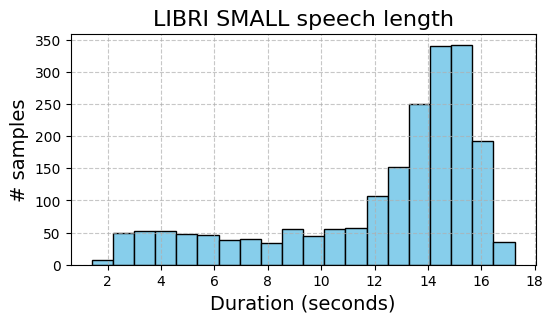

>>> Durations
min:	1.41 seconds
mean:	12.27 seconds
max:	17.24 seconds


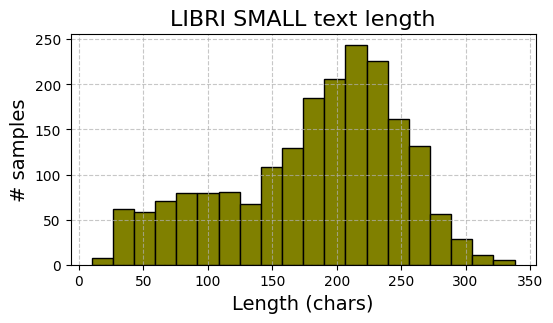

>>> Lengths
min:	10.00 chars
mean:	181.93 chars
max:	338.00 chars


In [30]:
plot_duration(train_set, title='libri small')
plot_text_length(train_set, title='libri small')

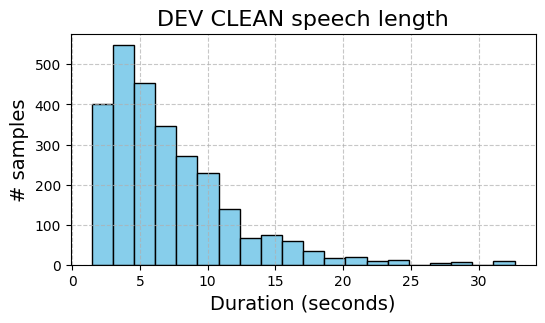

>>> Durations
min:	1.45 seconds
mean:	7.18 seconds
max:	32.65 seconds


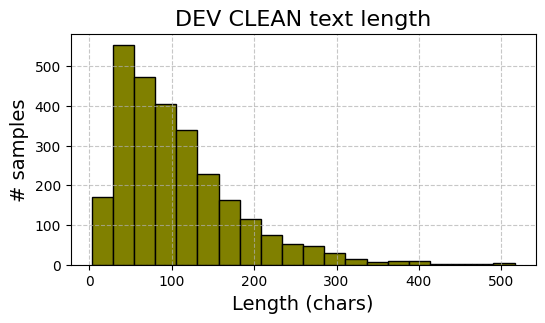

>>> Lengths
min:	3.00 chars
mean:	106.72 chars
max:	516.00 chars


In [31]:
plot_duration(test_set, title='dev clean')
plot_text_length(test_set, title='dev clean')

## Training 🥋
- a data collator: we pad input sequences dinamically, i.e. training samples are padded to the longest sequence in their batch
- evaluation metric: Word Error Rate (WER)
- checkpoint: load model card

The DataCollator Class was copied from [this repo](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81)

In [79]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [80]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Metrics - Word Error Rate
- we use a greedy decoding approach, i.e. taking the argmax along the logit vector (most probable character)
- we transform the encoded labels back tot the original string replacing `-100` with `pad_token_id`

In [81]:
wer_metric = load_metric("wer", trust_remote_code=True)

C:\Users\marco\AppData\Local\Temp\ipykernel_524\511016450.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer", trust_remote_code=True)


In [82]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

We are now ready to load the checkpoint from the Hugging Face Hub

In [83]:
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)

c:\Users\marco\.conda\envs\exp\Lib\site-packages\transformers\configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.bias', 'lm_head.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [84]:
model.freeze_feature_encoder()

In [85]:
training_args = TrainingArguments(
  output_dir="wav2vec2-base",
  group_by_length=True,
  per_device_train_batch_size=8,
  evaluation_strategy="steps",
  num_train_epochs=10,
  fp16=True,
  gradient_checkpointing=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=50,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=100,
  save_total_limit=2,
)

c:\Users\marco\.conda\envs\exp\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_set,
    eval_dataset=dev_clean,
    tokenizer=processor.feature_extractor,
)
trainer.train()